In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    fbeta_score,
    precision_score,
    recall_score
)

# ✅ Add project root to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [13]:
import shutil

# ✅ Create a clean copy for evaluation
source_path = os.path.join("..", "data", "labeled_data.csv")
eval_path = os.path.join("..", "data", "labeled_data_eval.csv")

# Only copy if it doesn't already exist
if not os.path.exists(eval_path):
    shutil.copy(source_path, eval_path)

In [15]:
from src.utils.config_loader import ConfigLoader
import joblib
import shutil

# ✅ Load config paths
config = ConfigLoader()
processed = config.get_processed_data_paths()
models = config.get_saved_model_paths()

# ✅ Load vectorizer and model
vectorizer = joblib.load(processed["tfidf_vectorizer"])
model = joblib.load(models["baseline_model"])

# ✅ Create a clean copy for evaluation
source_path = os.path.join("..", "data", "labeled_data.csv")
eval_path = os.path.join("..", "data", "labeled_data_eval.csv")

if not os.path.exists(eval_path):
    shutil.copy(source_path, eval_path)

# ✅ Load and standardize the copy
df = pd.read_csv(eval_path)

# ✅ Rename columns only in the copy
df = df.rename(columns={"comment": "text", "label_iD": "label"})

# ✅ Prepare inputs
X = vectorizer.transform(df["text"].astype(str))
y_true = df["label"].astype(int)
y_pred = model.predict(X)

# ✅ Label mapping
LABEL_MAP = {
    0: "bullying", 1: "non_bullying", 2: "offensive", 3: "racist", 4: "sexist",
    5: "abusive", 6: "clean", 7: "no_hate", 8: "harassing", 9: "personal_attacks"
}
label_names = [LABEL_MAP[i] for i in sorted(LABEL_MAP)]

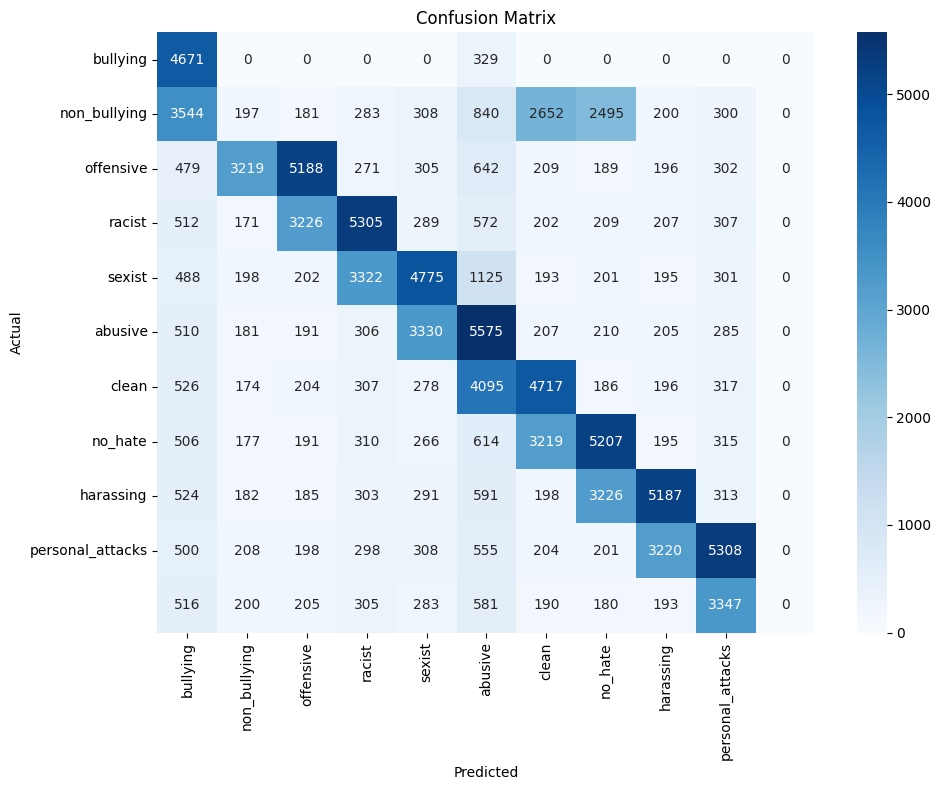

In [16]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

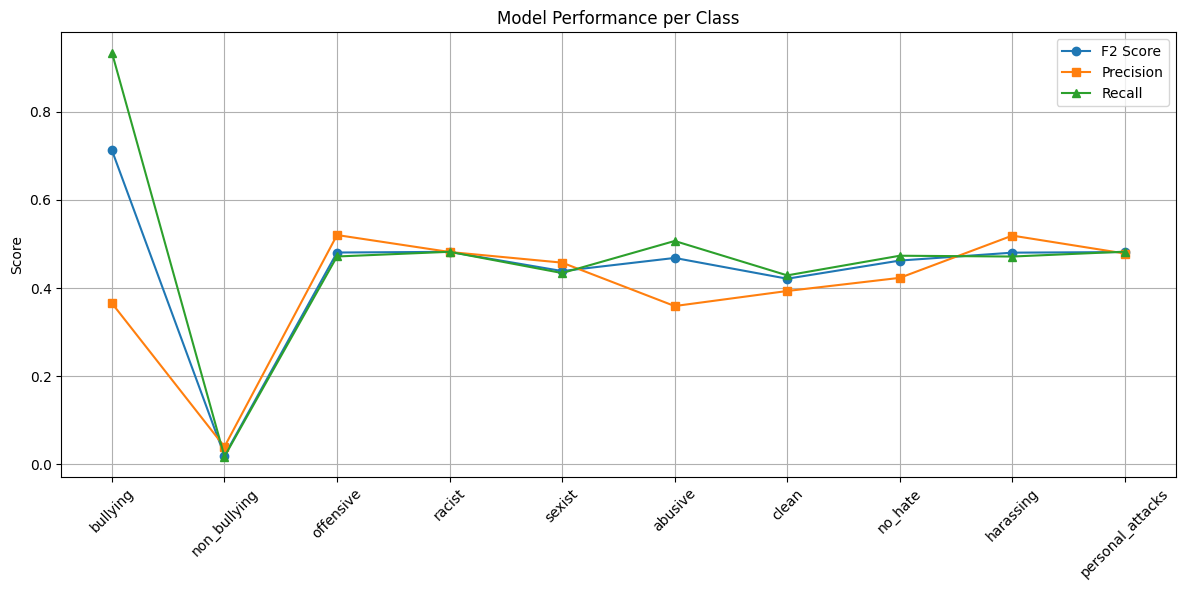

In [17]:
f2_scores = fbeta_score(y_true, y_pred, beta=2, average=None, labels=sorted(LABEL_MAP))
precisions = precision_score(y_true, y_pred, average=None, labels=sorted(LABEL_MAP))
recalls = recall_score(y_true, y_pred, average=None, labels=sorted(LABEL_MAP))

plt.figure(figsize=(12, 6))
plt.plot(label_names, f2_scores, marker='o', label='F2 Score')
plt.plot(label_names, precisions, marker='s', label='Precision')
plt.plot(label_names, recalls, marker='^', label='Recall')
plt.xticks(rotation=45)
plt.title("Model Performance per Class")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# ✅ Auto-build label map from actual data
unique_labels = sorted(df["label"].unique())
label_names = sorted(df["label_name"].unique(), key=lambda name: unique_labels[df[df["label_name"] == name]["label"].iloc[0]])
report = classification_report(
    y_true,
    y_pred,
    labels=unique_labels,
    target_names=label_names,
    output_dict=True,
    zero_division=0
)

c:\Users\priya\.conda\envs\verma\lib\site-packages\sklearn\metrics\_classification.py:2964: UserWarning: labels size, 11, does not match size of target_names, 10
  warnings.warn(


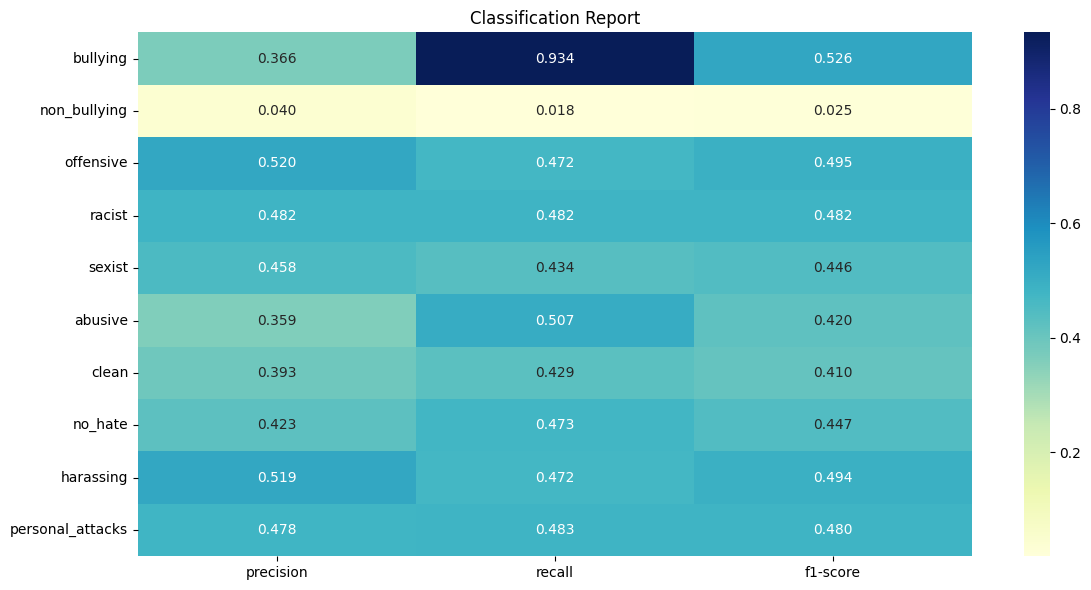

In [24]:
#heat map visualization
df_report = pd.DataFrame(report).transpose().round(3)
heatmap_data = df_report.drop(columns=["support"], errors="ignore")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.iloc[:-3], annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Classification Report")
plt.tight_layout()
plt.show()

In [25]:
# -------------------------------------
# 📊 Macro/Micro/Weighted F2 Scores
# -------------------------------------
f2_macro = fbeta_score(y_true, y_pred, beta=2, average='macro')
f2_micro = fbeta_score(y_true, y_pred, beta=2, average='micro')
f2_weighted = fbeta_score(y_true, y_pred, beta=2, average='weighted')

print("F2 Macro:", round(f2_macro, 4))
print("F2 Micro:", round(f2_micro, 4))
print("F2 Weighted:", round(f2_weighted, 4))

F2 Macro: 0.4044
F2 Micro: 0.4194
F2 Weighted: 0.4059


In [34]:
#Matthews Correlation Coefficient
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", round(mcc, 4))

#Cohen's Kappa

from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa:", round(kappa, 4))

#Hamming Loss

from sklearn.metrics import hamming_loss
hloss = hamming_loss(y_true, y_pred)
print("Hamming Loss:", round(hloss, 4))

#Per-Class ROC AUC

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_prob = model.predict_proba(X)
y_bin = label_binarize(y_true, classes=sorted(df["label"].unique()))
auc_scores = roc_auc_score(y_bin, y_prob, average=None)
for i, score in enumerate(auc_scores):
    print(f"AUC for {label_names[i]}: {round(score, 4)}")

Matthews Correlation Coefficient: 0.362
Cohen's Kappa: 0.3594
Hamming Loss: 0.5806
AUC for bullying: 0.9724
AUC for non_bullying: 0.698
AUC for offensive: 0.7951
AUC for racist: 0.7685
AUC for sexist: 0.7688
AUC for abusive: 0.7975
AUC for clean: 0.7684
AUC for no_hate: 0.7638
AUC for harassing: 0.8023
AUC for personal_attacks: 0.794


In [29]:
# Ensure folder exists
os.makedirs("saved_models", exist_ok=True)

# Save confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("saved_models/confusion_matrix.png")
plt.close()

# Save F2/Precision/Recall chart
plt.figure(figsize=(12, 6))
plt.plot(label_names, f2_scores, marker='o', label='F2 Score')
plt.plot(label_names, precisions, marker='s', label='Precision')
plt.plot(label_names, recalls, marker='^', label='Recall')
plt.xticks(rotation=45)
plt.title("Model Performance per Class")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("saved_models/performance_chart.png")
plt.close()

# Save classification report heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report")
plt.tight_layout()
plt.savefig("saved_models/classification_report.png")
plt.close()